In [1]:
#!pip install ruamel.yaml

In [2]:
import networkx as nx
import math
import numpy as np
import scipy.spatial
import io
from ruamel.yaml import YAML
import ruamel.yaml

In [3]:
def distance_to_bandwidth(d):
    # Network with average bandwidth = 6.5 Mbps
    a = 283230
    return math.log2(1 + a / (d ** 2))

In [4]:
# Needs a perfect square number of nodes to work correctly
def generate_grid_graph(length: int, width: int):
    x_pos = np.arange(1, length + 1) * (150 / length)
    y_pos = np.arange(1, width + 1) * (150 / width)

    pos_arr = []
    for i in range(len(x_pos)):
        for j in range(len(y_pos)):
            pos_arr.append((x_pos[i], y_pos[j]))

    num_nodes = int(length * width)
    comm_graph = nx.complete_graph(num_nodes)
    for p in range(len(pos_arr)):
        comm_graph.nodes()[p]['pos'] = pos_arr[p]
    for j in comm_graph.edges():
        u = j[0]
        v = j[1]
        dist = scipy.spatial.distance.euclidean(comm_graph.nodes[u]["pos"], comm_graph.nodes[v]["pos"])
        w = distance_to_bandwidth(dist)
        comm_graph[u][v]["weight"] = w
        comm_graph[u][v]['name'] = f"{u}-{v}"

    return comm_graph

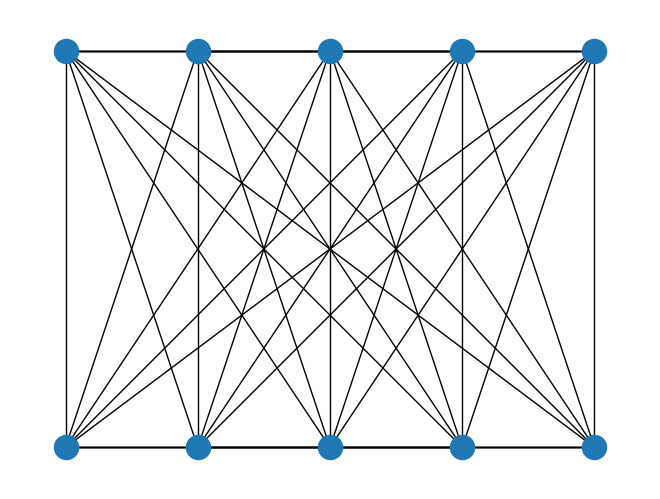

In [5]:
g = generate_grid_graph(5, 2)
pos = nx.get_node_attributes(g,'pos')
nx.draw(g, pos = pos)

In [6]:
def generate_ngon_graph(num_nodes: int):
    x = 150 // 2
    y = 150 // 2
    r = 150 // 2
    pos_arr = []
    for i in range(num_nodes):
        pos = (x + r * math.cos(2 * math.pi * (i / num_nodes)), y + r * math.sin(2 * math.pi * (i / num_nodes)))
        pos_arr.append(pos)
    comm_graph = nx.complete_graph(num_nodes)
    for p in range(len(pos_arr)):
        comm_graph.nodes()[p]['pos'] = pos_arr[p]
    for j in comm_graph.edges():
        u = j[0]
        v = j[1]
        dist = scipy.spatial.distance.euclidean(comm_graph.nodes[u]["pos"], comm_graph.nodes[v]["pos"])
        w = distance_to_bandwidth(dist)
        comm_graph[u][v]["weight"] = w
        comm_graph[u][v]['name'] = f"{u}-{v}"

    return comm_graph

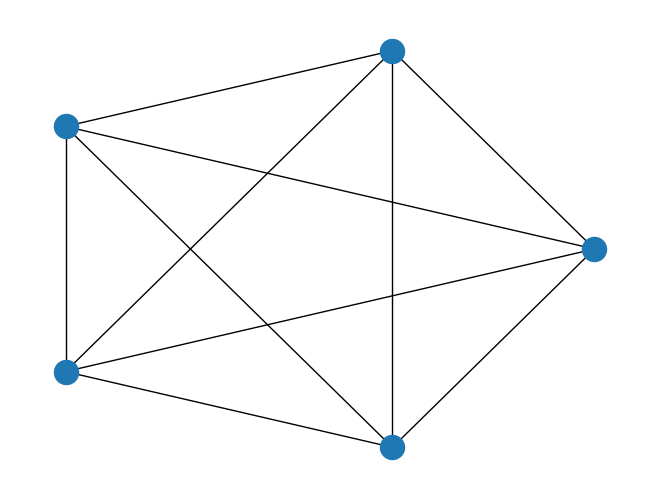

In [7]:
g = generate_ngon_graph(5)
pos = nx.get_node_attributes(g,'pos')
nx.draw(g, pos = pos)

In [8]:
def generate_cluster_graph(num_nodes: int, num_clusters: int):
    nodes_per_cluster = num_nodes // num_clusters
    center_x = 150 // 2
    center_y = 150 // 2
    global_r = 150 // 2
    pos_arr = []
    for i in range(num_clusters):
        cluster_x = center_x + global_r * math.cos(2 * math.pi * (i / num_clusters))
        cluster_y = center_y + global_r * math.sin(2 * math.pi * (i / num_clusters))
        # Should be some small radius - the nodes in each cluster should be pretty close together
        cluster_r = 150 // num_nodes
        for j in range(nodes_per_cluster):
            pos = (cluster_x + cluster_r * math.cos(2 * math.pi * (j / nodes_per_cluster)), cluster_y + cluster_r * math.sin(2 * math.pi * (j / nodes_per_cluster)))
            pos_arr.append(pos)

    comm_graph = nx.complete_graph(num_nodes)
    for p in range(len(pos_arr)):
        comm_graph.nodes()[p]['pos'] = pos_arr[p]
    for j in comm_graph.edges():
        u = j[0]
        v = j[1]
        dist = scipy.spatial.distance.euclidean(comm_graph.nodes[u]["pos"], comm_graph.nodes[v]["pos"])
        w = distance_to_bandwidth(dist)
        comm_graph[u][v]["weight"] = w
        comm_graph[u][v]['name'] = f"{u}-{v}"

    return comm_graph

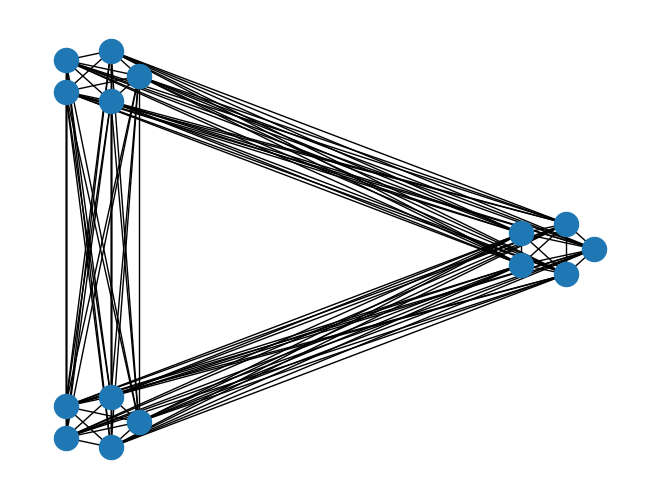

In [9]:
g = generate_cluster_graph(num_nodes = 15, num_clusters = 3)
pos = nx.get_node_attributes(g,'pos')
nx.draw(g, pos = pos)

In [14]:
def node_name_from_num(cluster_name: str, num: int):
    if num == 1:
        node_name = cluster_name
    elif num < 10:
        node_name = f"{cluster_name}-m0{num}"
    else:
        node_name = f"{cluster_name}-m{num}"

    return node_name

def create_chaosmesh_yaml(cluster_name: str, g: nx.Graph):
    num_nodes = len(g.nodes())
    # Node names are just numbered 1 to n
    # Exclude the last node b/c it won't have any connections
    for u in range(num_nodes - 1):
        # Node in graph is 0-indexed
        node_name = node_name_from_num(cluster_name, u + 1)

        template_list = []
        template_children = []

        for v in range(u + 1, num_nodes):
            # This is bandwidth in megabits per sec
            bandwidth = g[u][v]['weight']
            # Bandwidth in kilobits per sec, rounded to integer
            rate = round(bandwidth * 1000)
            neighbor_name = node_name_from_num(cluster_name, v + 1)

            workflow_name = f"{node_name}-{neighbor_name}"
            workflow_data = {
                "name": workflow_name,
                "templateType": "NetworkChaos",
                "networkChaos": {
                    "action": "bandwidth",
                    "mode": "all",
                    "selector": {
                        "namespaces": [
                          "default"
                        ],
                        "nodes": [
                            node_name
                        ]
                    } ,
                    "bandwidth": {
                        "rate": f'{rate}kbps',
                        "limit": 1000000,
                        "buffer": 1000000,
                    },
                    "direction": "both",
                    "target": {
                        "mode": "all",
                        "selector": {
                            "namespaces": [
                                "default"
                            ],
                            "nodes": [
                                neighbor_name
                            ]
                        }
                    }
                }
            }

            template_list.append(workflow_data)
            template_children.append(workflow_name)

        data = {
            "apiVersion": "chaos-mesh.org/v1alpha1",
            "kind": "Workflow",
            "metadata": {
                "name": f"{node_name}-connections"
            },
            "spec": {
                "entry": f"{node_name}-workflow",
                "templates": [
                    {
                        "name": f"{node_name}-workflow",
                        "templateType": "Parallel",
                        "children": template_children,
                    },
                    *template_list
                ]
            }
        }
        config_step_dir = "/Users/arjun/Desktop/GitHub/SEIFER/src/system_init_job/get_system_info_container/pkg"
        inference_step_dir = "/Users/arjun/Desktop/GitHub/SEIFER/src/dispatcher_pod/config_step/deploy_container/pkg"
        yaml = YAML()
        yaml.default_flow_style=False
        with io.open(f"{config_step_dir}/configs/{node_name}.yaml", 'x', encoding='utf8') as outfile:
            yaml.dump(data, outfile)
        with io.open(f"{inference_step_dir}/configs/{node_name}.yaml", 'x', encoding='utf8') as outfile:
            yaml.dump(data, outfile)

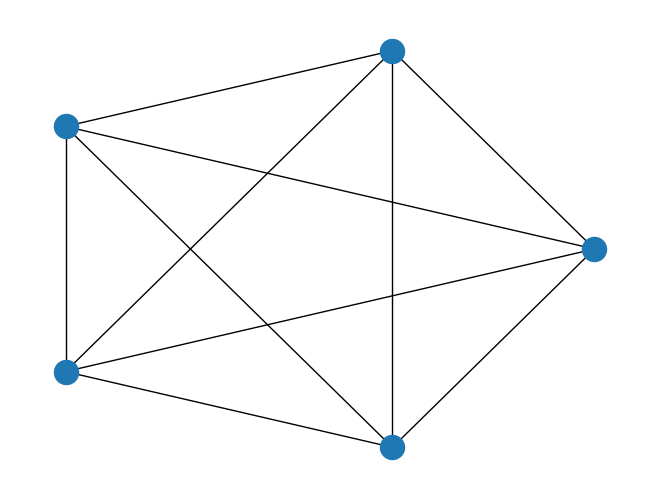

In [15]:
cluster_name = "5-node-cluster"
g = generate_ngon_graph(5)
pos = nx.get_node_attributes(g,'pos')
nx.draw(g, pos = pos)
create_chaosmesh_yaml(cluster_name, g)